In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from mingpt.bpe import BPETokenizer

import matplotlib.pyplot as plt
import numpy as np

set_seed(3407)

In [2]:
use_mingpt = True # use minGPT or huggingface/transformers model?
model_type = 'gpt2'
device = 'cuda'

In [3]:
if use_mingpt:
    model = GPT.from_pretrained(model_type)
else:
    model = GPT2LMHeadModel.from_pretrained(model_type)
    model.config.pad_token_id = model.config.eos_token_id # suppress a warning

# ship model to device and set to eval mode
model.to(device)
model.eval();

In [4]:
def generate(prompt='', num_samples=10, steps=20, do_sample=False):
        
    # tokenize the input prompt into integer input sequence
    if use_mingpt:
        tokenizer = BPETokenizer()
        if prompt == '':
            # to create unconditional samples...
            # manually create a tensor with only the special <|endoftext|> token
            # similar to what openai's code does here https://github.com/openai/gpt-2/blob/master/src/generate_unconditional_samples.py
            x = torch.tensor([[tokenizer.encoder.encoder['<|endoftext|>']]], dtype=torch.long)
        else:
            x = tokenizer(prompt).to(device)
    else:
        tokenizer = GPT2Tokenizer.from_pretrained(model_type)
        if prompt == '': 
            # to create unconditional samples...
            # huggingface/transformers tokenizer special cases these strings
            prompt = '<|endoftext|>'
        encoded_input = tokenizer(prompt, return_tensors='pt').to(device)
        x = encoded_input['input_ids']
    
    # we'll process all desired num_samples in a batch, so expand out the batch dim
    x = x.expand(num_samples, -1)

    # forward the model `steps` times to get samples, in a batch
    y, attns, logits, tok_emb = model.generate(x, max_new_tokens=steps, do_sample=do_sample, return_logits=True, save_grad=True)
    
    for i in range(num_samples):
        out = tokenizer.decode(y[i].cpu().squeeze())
        print('-'*80)
        print(out)

    return attns, out, logits, tok_emb

In [5]:
prompt = "Harvard is a university in"
attns, out, logits, tok_emb = generate(prompt=prompt, num_samples=1, steps=2)

--------------------------------------------------------------------------------
Harvard is a university in the United


In [6]:
tokenizer = BPETokenizer()
encoded_input = tokenizer(out, return_tensors='pt').to(device)

In [7]:
encoded_input

tensor([[13587, 10187,   318,   257,  6403,   287,   262,  1578]],
       device='cuda:0')

In [8]:
tokens = [tokenizer.decode(token.unsqueeze(0)) for token in encoded_input[0]]

In [9]:
tokens

['Har', 'vard', ' is', ' a', ' university', ' in', ' the', ' United']

In [163]:
# logits[0, torch.argmax(logits, dim=-1)].backward()

In [164]:
# tok_emb.grad

## 1. Saliency

In [6]:
grads = torch.autograd.grad(tuple(torch.flatten(logits)), tok_emb, retain_graph=True)

In [7]:
aggregated_grads = []
for grad, inp in zip(grads, tok_emb):
    # aggregated_grads.append(torch.norm(grad * inp, dim=-1))
    # aggregated_grads.append(grad.abs().max(-1).values)
    aggregated_grads.append(grad.abs().mean(-1))
    # aggregated_grads.append(grad.abs().min(-1).values)

In [11]:
aggregated_grads[0].shape

torch.Size([1, 7])

In [20]:
a = []
a.append(aggregated_grads[0].cpu().detach()[0].tolist())

In [21]:
a

[[11974.3662109375,
  13841.138671875,
  8753.30078125,
  4883.1728515625,
  10322.05859375,
  5143.65185546875,
  12913.8232421875]]

NameError: name 'tokens' is not defined

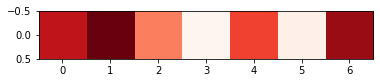

In [8]:
plt.imshow(aggregated_grads[0].cpu().detach(), cmap="Reds")
plt.xticks(ticks=np.arange(len(tokens[:-1])), labels=tokens[:-1], fontsize=12, rotation = -35)
plt.yticks(ticks=[])
plt.show()

## 2. Attention at one layer one head

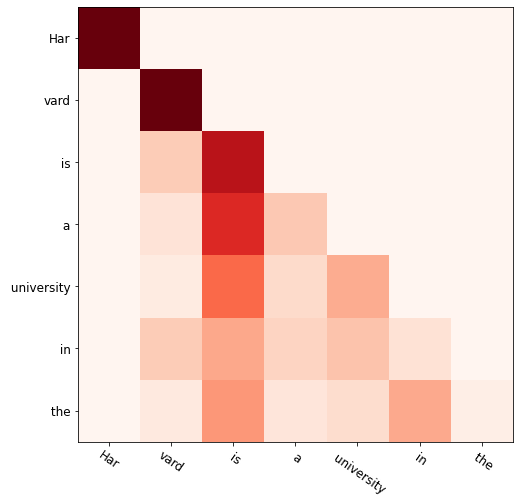

In [168]:
head = 8

plt.figure(figsize=(8, 8))
plt.imshow(attns["attn_layer_11"][0, head].detach().cpu().numpy(), cmap="Reds")
plt.yticks(ticks=np.arange(len(tokens[:-1])), labels=tokens[:-1], fontsize=12,)
plt.xticks(ticks=np.arange(len(tokens[:-1])), labels=tokens[:-1], fontsize=12, rotation = -35)
plt.show()

## 2.1 Attention at one layer one head (exclude first null attn)

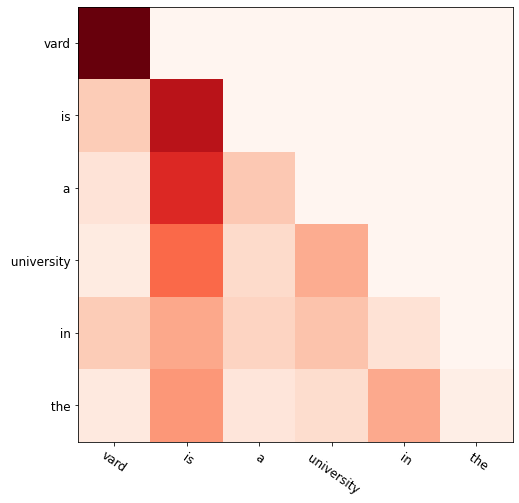

In [169]:
plt.figure(figsize=(8, 8))
plt.imshow(attns["attn_layer_11"][0, head][..., 1:, 1:].detach().cpu().numpy(), cmap="Reds")
plt.yticks(ticks=np.arange(len(tokens[1:-1])), labels=tokens[1:-1], fontsize=12,)
plt.xticks(ticks=np.arange(len(tokens[1:-1])), labels=tokens[1:-1], fontsize=12, rotation = -35)
plt.show()

## 3. Attention of head aggregated by summing all layers

In [170]:
agg_attn = torch.zeros_like(attns["attn_layer_0"][0, head])
for attn in attns.keys():
    agg_attn += attns[attn][0, head]

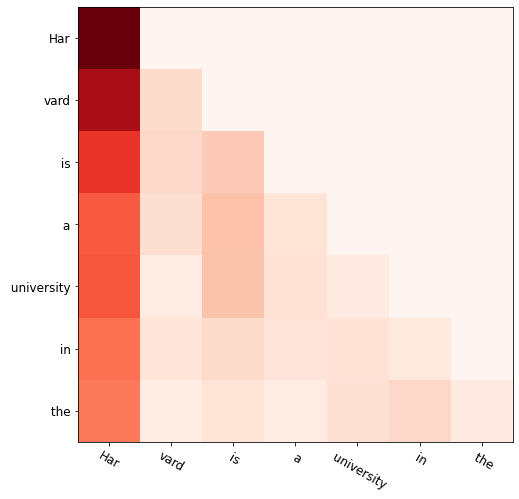

In [171]:
plt.figure(figsize=(8, 8))
plt.imshow(agg_attn.detach().cpu().numpy(), cmap="Reds")
plt.yticks(ticks=np.arange(len(tokens[:-1])), labels=tokens[:-1], fontsize=12,)
plt.xticks(ticks=np.arange(len(tokens[:-1])), labels=tokens[:-1], fontsize=12, rotation = -30)
plt.show()

## 3.1 Attention of head aggregated by summing all layers (Exclude first null attention)

In [172]:
agg_attn = torch.zeros_like(attns["attn_layer_0"][0, head])
for attn in attns.keys():
    agg_attn += attns[attn][0, head]

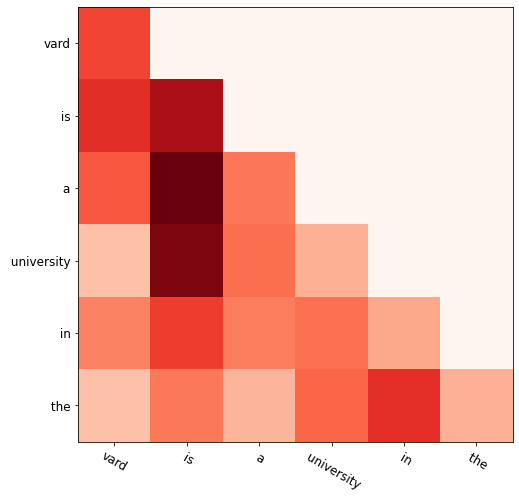

In [173]:
plt.figure(figsize=(8, 8))
plt.imshow(agg_attn.detach().cpu().numpy()[1:, 1:], cmap="Reds")
plt.yticks(ticks=np.arange(len(tokens[1:-1])), labels=tokens[1:-1], fontsize=12,)
plt.xticks(ticks=np.arange(len(tokens[1:-1])), labels=tokens[1:-1], fontsize=12, rotation = -30)
plt.show()

## 4. Attention Rollout

In [174]:
head = 11
agg_attn = torch.ones_like(attns["attn_layer_0"][0, head])

for i in range(11):
    for j in range(i):
        agg_attn *= (0.5 * attns[f"attn_layer_{j}"][0, head] + 
                     0.5 * torch.eye(attns[attn].shape[-2],attns[attn].shape[-1]).to(device))

In [118]:
def attn_rollout(layer_n, head):
    cur_layer_attn = (0.5 * attns[f"attn_layer_{layer_n}"][0, head] + 
                      0.5 * torch.eye(attns[attn].shape[-2],attns[attn].shape[-1]).to(device))
    if layer_n == 0:
        return cur_layer_attn
    else:
        return cur_layer_attn * attn_rollout(layer_n - 1, head)

In [119]:
def attn_rollout(layer_n, head):
    cur_layer_attn = attns[f"attn_layer_{layer_n}"][0, head][..., 1:, 1:]
    if layer_n == 0:
        return cur_layer_attn
    else:
        return cur_layer_attn * attn_rollout(layer_n - 1, head)

In [120]:
agg_attn = attn_rollout(11, 0)

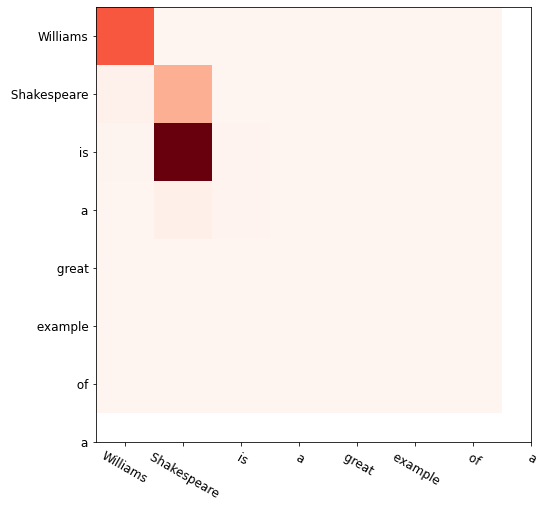

In [121]:
plt.figure(figsize=(8, 8))
plt.imshow(agg_attn.detach().cpu().numpy(), cmap="Reds")
plt.yticks(ticks=np.arange(len(tokens[:-1])), labels=tokens[:-1], fontsize=12,)
plt.xticks(ticks=np.arange(len(tokens[:-1])), labels=tokens[:-1], fontsize=12, rotation = -30)
plt.show()

## 5. Modularized

In [10]:
def generate(prompt, tokenizer, model, num_samples=1, steps=20, do_sample=False, saliency=False):    
    x = tokenizer(prompt).to(args.device)
    # we'll process all desired num_samples in a batch, so expand out the batch dim
    x = x.expand(num_samples, -1)

    # forward the model `steps` times to get samples, in a batch
    # For consistency reason, do not sample output logits. We want results to be reproducible
    output = model.generate(x, max_new_tokens=steps, do_sample=do_sample, 
                            return_logits=saliency, save_grad=saliency)
    
    y = output[0]
    interm_output = output[1:]
    
    out = tokenizer.decode(y[0].cpu().squeeze())

    return y, out, interm_output

In [207]:
def main(args):
    set_seed(args.random_state)
    
    output_dict = {"input_prompt": args.prompt}
    
    model = GPT.from_pretrained(args.lang_model)

    # ship model to device and set to eval mode
    model.to(args.device)
    model.eval();
    tokenizer = BPETokenizer()
    
    out = args.prompt
    
    input_tokens = tokenizer(args.prompt)
    input_tokens = [tokenizer.decode(tok.unsqueeze(0)) for tok in input_tokens[0]]
    output_dict["input_tokens"] = input_tokens
    for i in range(args.num_tokens):
        y, out, interm_output = generate(prompt=out,
                                         tokenizer=tokenizer, 
                                         model=model,
                                         num_samples=1, 
                                         steps=1,
                                         saliency=args.saliency)

        token = tokenizer.decode(y[0][-1].unsqueeze(0))
        
        if "tokens" not in output_dict.keys():
            output_dict["tokens"] = []
        output_dict["tokens"].append(token)

        if args.saliency:
            logits = interm_output[1]
            tok_emb = interm_output[2]
            grads = torch.autograd.grad(tuple(torch.flatten(logits)), tok_emb, retain_graph=True)
            aggregated_grads = []
            for grad, inp in zip(grads, tok_emb):
                assert args.saliency_metric in ["mean", "inputXGrad"]
                if args.saliency_metric == "inputXGrad":
                    aggregated_grads.append(torch.norm(grad * inp, dim=-1))
                elif args.saliency_metric == "mean":
                    aggregated_grads.append(grad.abs().mean(-1))
                
            if "saliency" not in output_dict.keys():
                output_dict["saliency"] = []
            output_dict["saliency"].append(aggregated_grads[0].cpu().detach()[0].tolist())
        
    output_dict["output_full_text"] = out
    output_dict["output_token_list"] = [tokenizer.decode(token.unsqueeze(0)) for token in y[0]]
    
    if args.attn_pairs:
        attn = interm_output[0]
        output_dict["key_attn_pairs"] = {}
        output_dict["key_attn_pairs_ind"] = []
        if args.agg_method == "max":
            agg_attn = torch.amax(attn[args.attn_layer_sel][0], dim=0).cpu().detach()[1:, 1:]
        elif args.agg_method == "mean":
            agg_attn = torch.mean(attn[args.attn_layer_sel][0], dim=0).cpu().detach()[1:, 1:]
            
        for i in range(agg_attn.shape[1]):
            key_ind = torch.argmax(agg_attn[i])
            if key_ind == i or i < args.num_tokens_buffed:
                continue
            iqr = torch.quantile(agg_attn[i][:i+1], 0.75) - torch.quantile(agg_attn[i][:i+1], 0.25)
            if 1.5 * iqr + torch.quantile(agg_attn[i][:i+1], 0.75) > agg_attn[i][key_ind]:
            # if 2 * torch.mean(agg_attn[i][:i+1]) > agg_attn[i][key_ind]:
                continue
            
            key_word = output_dict["output_token_list"][key_ind+1].strip(" ")
            cur_word = output_dict["output_token_list"][i+1].strip(" ")
            
            if not (cur_word.isalpha() and key_word.isalpha()):
                continue
  
            key_word_ind = key_word + f"_{int(key_ind.cpu()+1)}"
            cur_word_ind = cur_word + f"_{i+1}"
            if key_word_ind not in output_dict["key_attn_pairs"].keys():
                output_dict["key_attn_pairs"][key_word_ind] = []
            output_dict["key_attn_pairs"][key_word_ind].append(cur_word_ind)
            
            output_dict["key_attn_pairs_ind"].append((key_word, cur_word, 
                                                  int(key_ind.cpu() + 1), i + 1))
                
    return output_dict, attn

In [218]:
import argparse

args = argparse.Namespace()
args.prompt = "Remember Music is an Android app for identifying the songs that you have"
# args.prompt = "Ha"
args.num_tokens = 50
args.lang_model = "gpt2"
args.random_state = 0
args.saliency = True
args.device = "cuda"
args.saliency_metric = "mean"
args.attn_layer_sel = "attn_layer_10"
args.agg_method = "mean"
args.num_tokens_buffed = 5
args.attn_pairs = True

In [222]:
out, attn = main(args)

In [220]:
out["output_full_text"]

"Remember Music is an Android app for identifying the songs that you have listened to on your phone. It's a great way to find out what's going on in your life.\n\n\n• Find out what's going on in your life by searching for the songs you've listened to on your phone.\n\n\n"

In [221]:
out["key_attn_pairs"], out["key_attn_pairs_ind"]

({'Music_1': ['for_6',
   'identifying_7',
   'the_8',
   'on_15',
   'in_31',
   'in_44',
   'searching_48',
   'on_56'],
  'songs_9': ['you_11',
   'have_12',
   'find_25',
   'out_26',
   'what_27',
   'Find_38',
   'out_39',
   'what_40',
   'for_49',
   'the_50'],
  'on_15': ['your_16'],
  'identifying_7': ['It_19', 'to_24'],
  'app_5': ['great_22'],
  'great_22': ['way_23'],
  'find_25': ['on_30'],
  'in_31': ['your_32'],
  'Find_38': ['on_43'],
  'life_33': ['your_45'],
  'listened_13': ['by_47', 'you_52'],
  'the_50': ['songs_51'],
  'to_14': ['listened_54'],
  'phone_17': ['your_57']},
 [('Music', 'for', 1, 6),
  ('Music', 'identifying', 1, 7),
  ('Music', 'the', 1, 8),
  ('songs', 'you', 9, 11),
  ('songs', 'have', 9, 12),
  ('Music', 'on', 1, 15),
  ('on', 'your', 15, 16),
  ('identifying', 'It', 7, 19),
  ('app', 'great', 5, 22),
  ('great', 'way', 22, 23),
  ('identifying', 'to', 7, 24),
  ('songs', 'find', 9, 25),
  ('songs', 'out', 9, 26),
  ('songs', 'what', 9, 27),
  (

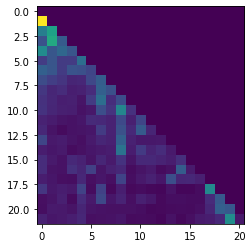

In [107]:
plt.imshow(torch.amax(attn[args.attn_layer_sel][0], dim=0).cpu().detach()[:, 1:])

In [124]:
torch.amax(attn[args.attn_layer_sel][0], dim=0).cpu().detach()[1:, 1:]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.4284, 0.5715, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.2501, 0.6058, 0.2857, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.4837, 0.2676, 0.3329, 0.2633, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.1774, 0.2635, 0.1736, 0.1745, 0.3618, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.3061, 0.2

In [122]:
agg_attn[6][:7]

tensor([0.2324, 0.1857, 0.1557, 0.1052, 0.1113, 0.2125, 0.2959, 0.0000])

In [149]:
agg_attn = torch.mean(attn[args.attn_layer_sel][0], dim=0).cpu().detach()[1:, 1:]
for i in range(agg_attn.shape[1]):
    key_ind = torch.argmax(agg_attn[i])
    print(out["output_token_list"][i+1])
    if key_ind == i or i < 5:
        continue
    iqr = torch.quantile(agg_attn[i][:i+1], 0.75) - torch.quantile(agg_attn[i][:i+1], 0.25)
    if 1.5 * iqr + torch.median(agg_attn[i][:i+1]) > agg_attn[i][key_ind]:
        continue
    print(key_ind)
    print(agg_attn[i][key_ind], torch.mean(agg_attn[i][:i+1]))
    print(out["output_token_list"][i+1], out["output_token_list"][key_ind+1])

 Music
 is
 an
 Android
 app
 for
tensor(0)
tensor(0.1076) tensor(0.0690)
 for  Music
 identifying
 the
tensor(6)
tensor(0.0959) tensor(0.0502)
 the  identifying
 songs
tensor(6)
tensor(0.0957) tensor(0.0477)
 songs  identifying
 that
tensor(8)
tensor(0.0898) tensor(0.0409)
 that  songs
 you
tensor(8)
tensor(0.0648) tensor(0.0275)
 you  songs
 have
tensor(8)
tensor(0.0756) tensor(0.0333)
 have  songs
 listened
tensor(8)
tensor(0.0564) tensor(0.0273)
 listened  songs
 to
tensor(8)
tensor(0.0621) tensor(0.0281)
 to  songs
 on
tensor(0)
tensor(0.0581) tensor(0.0294)
 on  Music
 your
tensor(14)
tensor(0.0799) tensor(0.0254)
 your  on
 phone
tensor(13)
tensor(0.0516) tensor(0.0243)
 phone  to
.
 It
's
tensor(18)
tensor(0.0621) tensor(0.0197)
's  It
 a
tensor(19)
tensor(0.0594) tensor(0.0208)
 a 's


In [94]:
torch.mean(attn[args.attn_layer_sel][0], dim=0).cpu().detach()[:, 1:][3]

tensor([0.0987, 0.1126, 0.0648, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])

In [64]:
out["output_full_text"]

"Remember Music is an Android app for identifying the songs that you have listened to on your phone. It's a great"

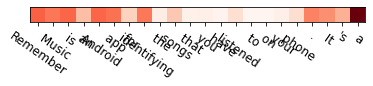

In [72]:
i = 9
tokens = out["input_tokens"] + out["tokens"][:i]
plt.imshow(np.array(out["saliency"][i]).reshape(1, -1), cmap="Reds")
plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, fontsize=12, rotation = -35)
plt.yticks(ticks=[])
plt.show()

In [49]:
tokens

['Remember',
 ' Music',
 ' is',
 ' an',
 ' Android',
 ' app',
 ' for',
 ' identifying',
 ' the',
 ' songs',
 ' that',
 ' you',
 ' have',
 ' listened']